<a href="https://colab.research.google.com/github/anamilanezi/google-data-analytics/blob/main/Sample_LatLong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1A6Ozzcfx-EqYeK5uwMx7-cTyyUMXIy0P)

<p align="right">
Photo by <a href="https://unsplash.com/@autumnstudio?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Autumn Studio</a> on <a href="https://unsplash.com/s/photos/bike-share?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a></p>
  

# **`CYCLISTIC BIKE SHARE`**


# Importing dataset

The data is already clean and prepared to analysis. The cleaning process is documented [here](https://www.kaggle.com/code/anamilanezi/google-capstone-project-cyclistic-bike-share). The clean dataframe uses only rides shorter than 240 minutes (4 hours).

The following libraries were used on this study:
* [Pandas](https://pandas.pydata.org/) for data cleaning, manipulation, organization, statistics and exploratory analysis
* [Seaborn](https://seaborn.pydata.org/) and [Matplotlib](https://matplotlib.org/) for data visuals 
* [Datetime](https://docs.python.org/3/library/datetime.html) for dates manipulation
* [Calendar](https://docs.python.org/3/library/calendar.html) to create month and week days dictionaries
* [h3](https://pypi.org/project/h3/) to calculate distance between coordinates
* [Shapely](https://pypi.org/project/Shapely/) to create point objects  
* [GeoPandas](https://geopandas.org/) to create geodataframes and plot maps 

<p align="justify">All data used in the study are made available by Lyft Bikes and Scooters, LLC which operates the City of Chicago’s. As part of a commitment with the City of Chicago to support bicycle as an alternative tranportation option, the service provides system data available to the public, subject to the terms and conditions of <a href="https://ride.divvybikes.com/data-license-agreement" target="_blank">this License Agreement.</a></p>

<p align="justify">The dataset doesn't provide personal and private information about the users, it's anonymized, comprehensive and represents current data making it a reliable and unbiased source.<p align="justify">

In [ ]:
!pip install h3
!pip install geopandas

In [ ]:
import h3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
import geopandas as gpd
from shapely.geometry import Point, Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Google Capstone Project/data/clean_data/240/clean_df.csv')

In [ ]:
df= pd.DataFrame(df)

In [ ]:
# Color palettes
my_palette = ['#3c9ab2', '#56a6ba', '#71b3c2', '#88b774', '#d1c74c', '#e8c520', '#e4b80d', '#e29e00', '#ea5c00', '#f22300']
customPalette = sns.set_palette(sns.color_palette(my_palette))

colors_member_casual = {"Member": '#88b774', "Casual": '#ea5c00' }
colors_day_of_week = {'Monday': '#3c9ab2', 'Tuesday': '#71b3c2', 'Wednesday': '#88b774', 'Thursday': '#ffde45', 'Friday': '#e4b80d', 'Saturday': '#ea5c00', 'Sunday': '#f22300'}


In [ ]:
# Create a list with months order from July 2021 - June 2022:
months_order = [7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6]

# Create a dictionary for months:
month_names = {(i): name for i, name in enumerate(calendar.month_name) if i != 0}
print(month_names)

# Creat a dictionary for week days
days = {name: i + 1 for i, name in enumerate(calendar.day_name)}
print(days)

# Saving days order 
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

{1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
{'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}


In [ ]:
# This summary shows inconsistent lat and long points outside Chicago area
df[['start_lat', 'start_lng', 'end_lat', 'end_lng']].describe().T

,count,mean,std,min,25%,50%,75%,max
start_lat,5883249.0,41.900612,0.047146,41.64,41.881032,41.898990,41.929540,45.635034
start_lng,5883249.0,-87.647190,0.030745,-87.84,-87.661501,-87.643241,-87.628361,-73.796477
end_lat,5883249.0,41.900844,0.047254,41.39,41.881034,41.899930,41.929546,42.168116
end_lng,5883249.0,-87.647369,0.030376,-88.97,-87.661535,-87.643353,-87.628579,-87.490000


In [ ]:
# Removing values outside Chicago
df = df.query('start_lat < 42.2')

In [ ]:
# Creating a column joining lng x lat (order used on plots)
df['start_station'] = [(xy) for xy in zip(df['start_lng'], df['start_lat'])]
df['end_station'] = [(xy) for xy in zip(df['end_lng'], df['end_lat'])]

In [ ]:
# Calculating distance using h2
df['distance'] = df.apply(lambda row: h3.point_dist((row['start_lat'], row['start_lng']), (row['end_lat'], row['end_lng']), unit='km'), axis=1)

In [ ]:
df = df.drop(['start_lat', 'start_lng', 'end_lat', 'end_lng'], axis=1)

In [ ]:
df[['distance', 'ride_length_minutes']].describe().T

,count,mean,std,min,25%,50%,75%,max
distance,5883248.0,2.167700,1.964664,0.00,0.891286,1.608377,2.841254,114.383699
ride_length_minutes,5883248.0,16.918476,19.737231,0.02,6.270000,11.130000,20.100000,239.970000


In [ ]:
for column in list(df.columns):
    unique = len(df[column].unique())
    pct = unique / len(df.index)
    print(f"[{column:<20}] has {unique:>7} unique values or {pct:>4.2%} of rows")

[ride_id             ] has 5883248 unique values or 100.00% of rows
[rideable_type       ] has       3 unique values or 0.00% of rows
[member_casual       ] has       2 unique values or 0.00% of rows
[started_at          ] has 4912308 unique values or 83.50% of rows
[ended_at            ] has 4912649 unique values or 83.50% of rows
[start_lat           ] has  493654 unique values or 8.39% of rows
[start_lng           ] has  471184 unique values or 8.01% of rows
[end_lat             ] has  371471 unique values or 6.31% of rows
[end_lng             ] has  342901 unique values or 5.83% of rows
[day_of_week         ] has       7 unique values or 0.00% of rows
[int_day_of_week     ] has       7 unique values or 0.00% of rows
[int_month           ] has      12 unique values or 0.00% of rows
[month               ] has      12 unique values or 0.00% of rows
[date                ] has     365 unique values or 0.01% of rows
[hour                ] has      24 unique values or 0.00% of rows
[ride_

In [ ]:
total = []
for i in range(1,13):
  month = month_names[i]
  num_rows = df.query(f'int_month == {i}')['ride_id'].count()
  total.append(num_rows)
  print(f"{month}: {num_rows}")

January: 103463
February: 115357
March: 283313
April: 370406
May: 633041
June: 766841
July: 819392
August: 801754
September: 753834
October: 629467
November: 359262
December: 247118


# Taking a samples

## Creating a sample from dataset using calculated sample size

6585 or more measurements/surveys are needed to have a confidence level of 99.9% that the real value is within ±2% of the measured/surveyed value. Comparing statistical summary from whole dataset and sample shows the similar results

In [ ]:
sample_df = df.sample(n=6758)

In [ ]:
sample_df = sample_df.sort_values(by=['started_at'])

Taking a statistical summary from our sample shows how close the values are:

In [ ]:
sample_df.describe().T

,count,mean,std,min,25%,50%,75%,max
int_day_of_week,6758.0,4.148861,2.003632,1.00,2.000000,4.000000,6.000000,7.000000
int_month,6758.0,7.250666,2.560136,1.00,5.000000,7.000000,9.000000,12.000000
hour,6758.0,14.259248,5.032083,0.00,11.000000,15.000000,18.000000,23.000000
ride_length_minutes,6758.0,17.187226,19.943664,0.02,6.220000,11.230000,20.345000,225.830000
distance,6758.0,2.178932,1.975820,0.00,0.868937,1.588133,2.897699,20.429775


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
int_day_of_week,5883248.0,4.113576,1.991628,1.00,2.000000,4.000000,6.000000,7.000000
int_month,5883248.0,7.237200,2.569783,1.00,5.000000,7.000000,9.000000,12.000000
hour,5883248.0,14.208997,5.047652,0.00,11.000000,15.000000,18.000000,23.000000
ride_length_minutes,5883248.0,16.918476,19.737231,0.02,6.270000,11.130000,20.100000,239.970000
distance,5883248.0,2.167700,1.964664,0.00,0.891286,1.608377,2.841254,114.383699


## Creating random samples by month  based on calculated sample size:
Minimun number of measurements that are needed to have a confidence level of 99.9% that the real value is within ±2% of the measured value.


In [ ]:
sample_size = [6350, 6391, 6608, 6644, 6694, 6706, 6710, 6709, 6705, 6694, 6641, 6585]
months = [df.query(f'int_month == {i}').sample(n=sample_size[i-1]) for i in range(1, 13)]

In [ ]:
sample_month_df = pd.concat(months, ignore_index=True)

In [ ]:
sample_month_df.describe().T

,count,mean,std,min,25%,50%,75%,max
int_day_of_week,79437.0,4.021388,1.990582,1.00,2.000000,4.00000,6.000000,7.000000
int_month,79437.0,6.536450,3.430754,1.00,4.000000,7.00000,10.000000,12.000000
hour,79437.0,14.042537,4.982142,0.00,11.000000,15.00000,18.000000,23.000000
ride_length_minutes,79437.0,15.555685,18.497524,0.02,5.770000,10.17000,18.470000,236.930000
distance,79437.0,2.076176,1.911259,0.00,0.851333,1.51966,2.719644,21.907123


In [ ]:
sample_month_df = sample_month_df.sort_values(by=['started_at'])

# Plotting Ride Length x Distance

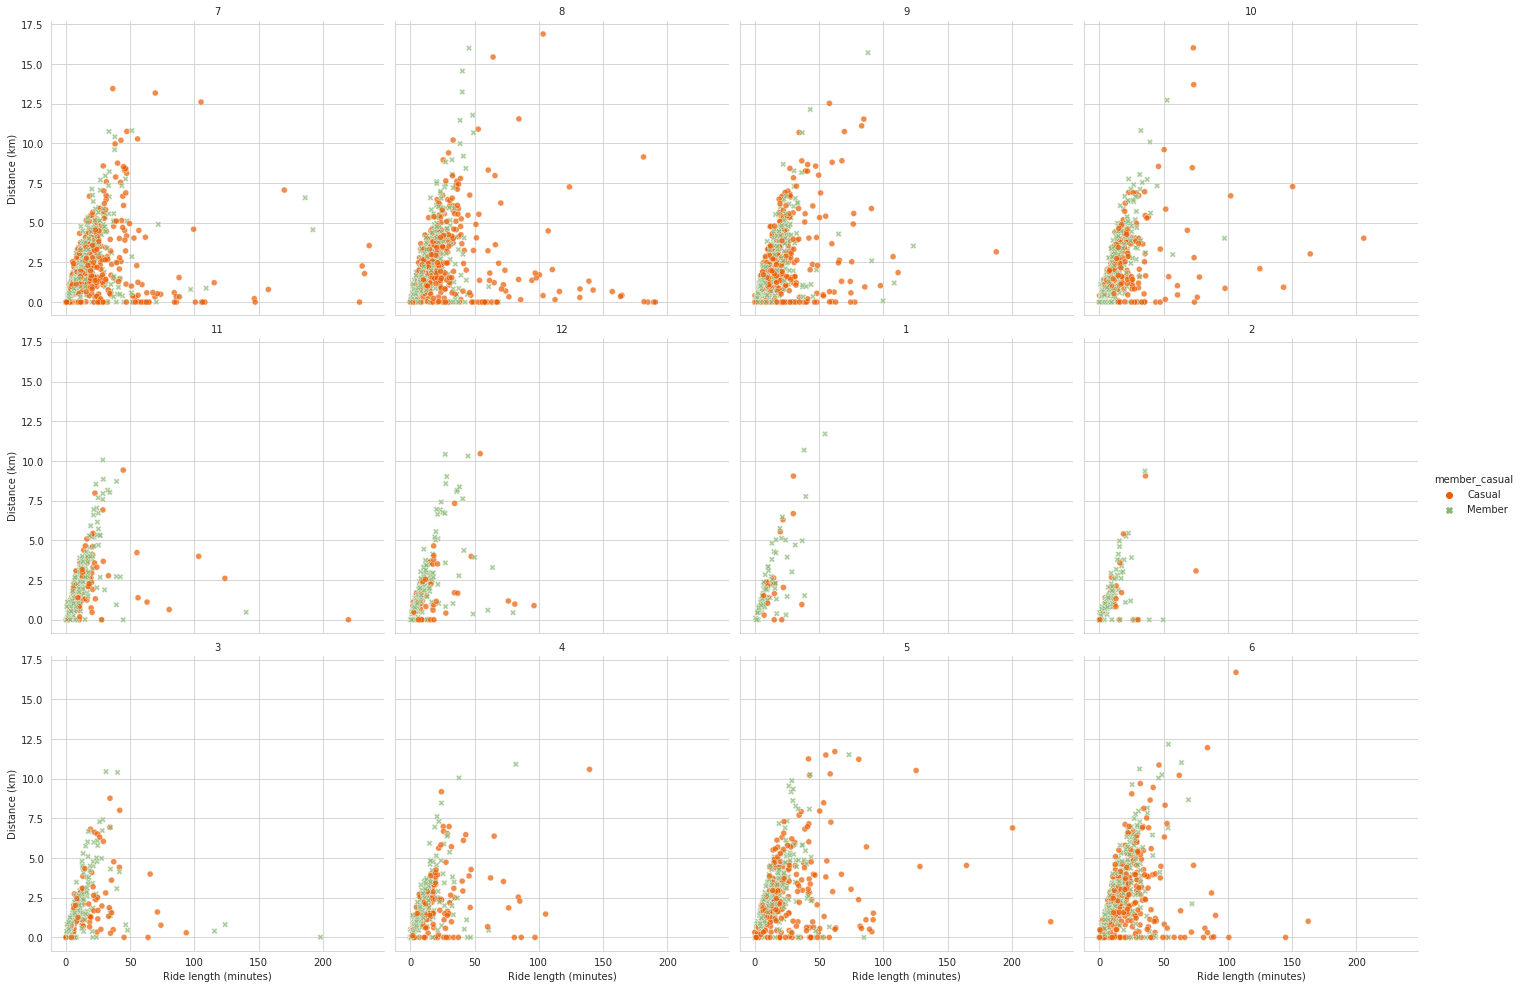

In [ ]:
with sns.axes_style('whitegrid'):
  f1 = sns.relplot(
  data=sample_df,
  x="ride_length_minutes", 
  y="distance", 
  hue="member_casual",
  style="member_casual",
  col="int_month", 
  col_order=months_order,
  col_wrap=4, 
  alpha=0.7, 
  palette=colors_member_casual)
  f1.set(title="Relation between ride length and distance", ylabel="Distance (km)", xlabel="Ride length (minutes)")
  f1.fig.subplots_adjust(top=.9)
  f1.set_titles(col_template="{col_name}")

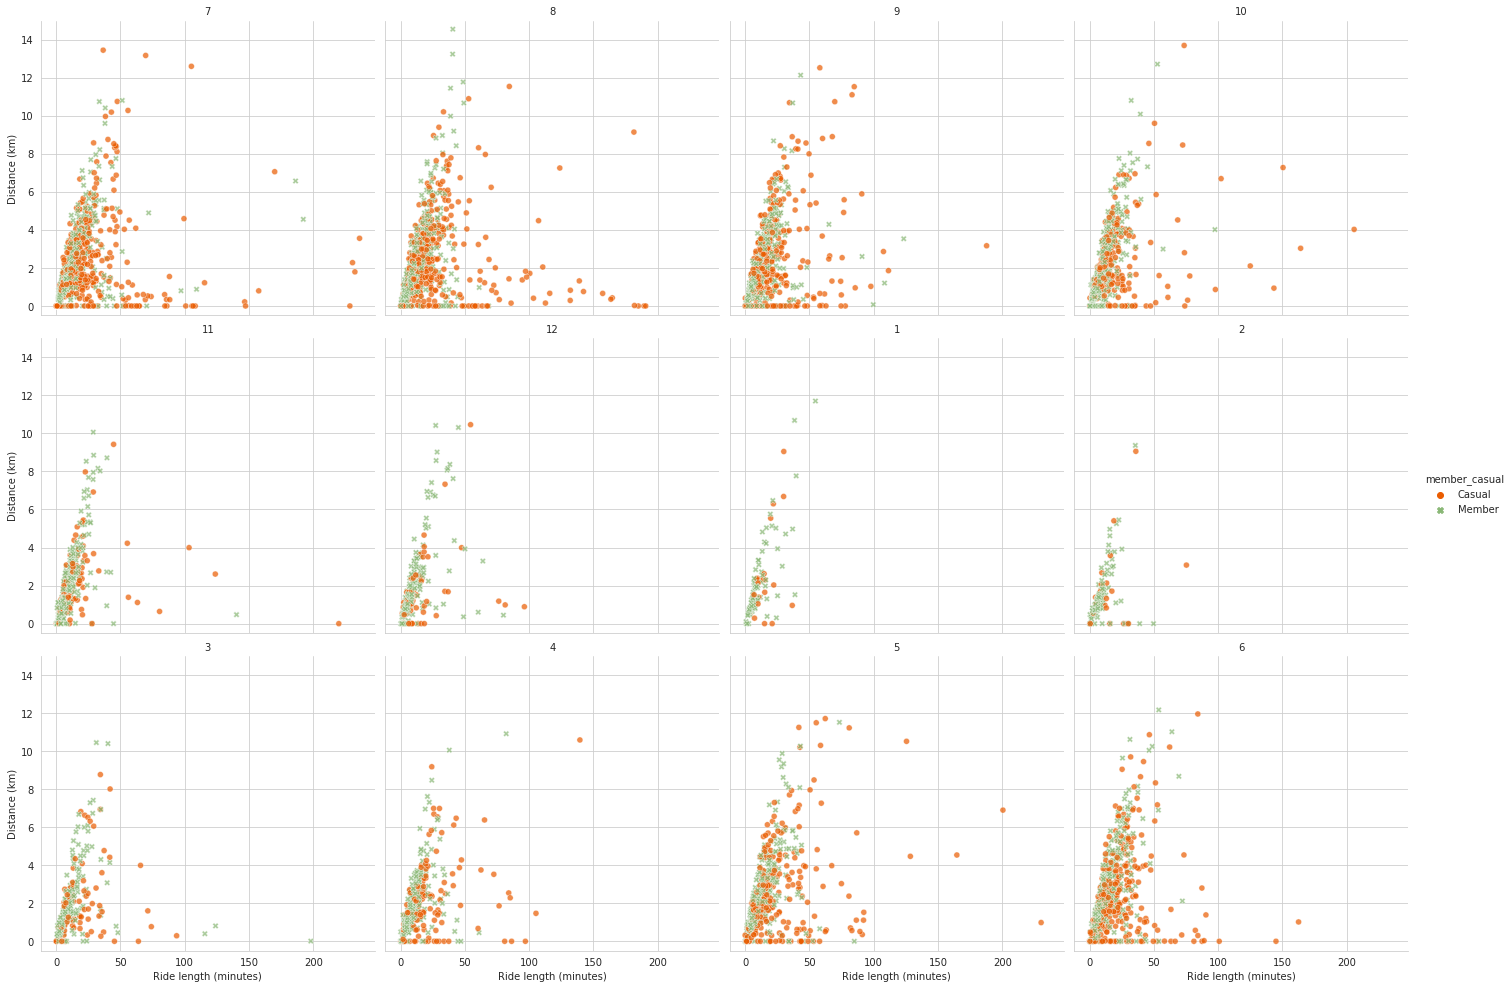

In [ ]:
with sns.axes_style('whitegrid'):
  f1 = sns.relplot(
  data=sample_df,
  x="ride_length_minutes", 
  y="distance", 
  hue="member_casual",
  style="member_casual",
  col="int_month", 
  col_order=months_order,
  col_wrap=4, 
  alpha=0.7, 
  palette=colors_member_casual)
  f1.set(title="Relation between ride length and distance", ylabel="Distance (km)", xlabel="Ride length (minutes)")
  f1.fig.subplots_adjust(top=.9)
  f1.set_titles(col_template="{col_name}")
  f1.set(ylim=(-0.5, 15))

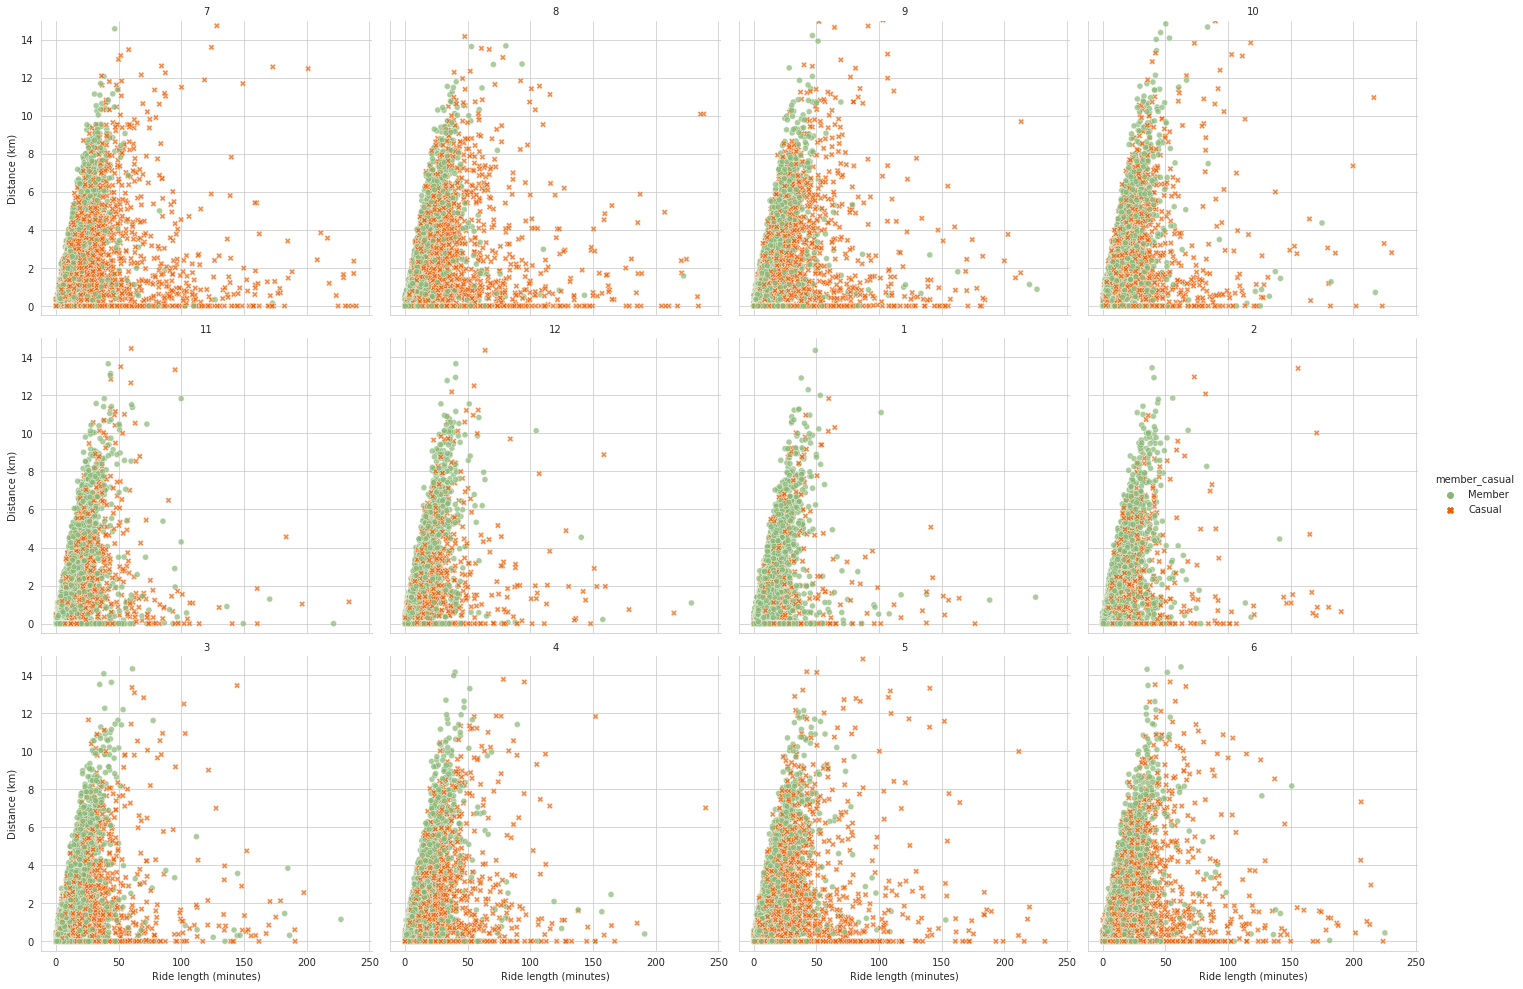

In [ ]:
with sns.axes_style('whitegrid'):
  f3 = sns.relplot(
  data=sample_month_df,
  x="ride_length_minutes", 
  y="distance", 
  hue="member_casual",
  style="member_casual",
  col="int_month", 
  col_order=months_order,
  col_wrap=4, 
  alpha=0.7, 
  palette=colors_member_casual)
  f3.set(title="Relation between ride length and distance", ylabel="Distance (km)", xlabel="Ride length (minutes)")
  f3.fig.subplots_adjust(top=.9)
  f3.set_titles(col_template="{col_name}")
  f3.set(ylim=(-0.5, 15))

# Grouping data by **Station**

## All costumers

In [ ]:
# Grouping Lat x Long points to see most used stations

grouped_stations = df[['start_station', 'end_station', 'ride_length_minutes', 'distance']].groupby(['start_station', 'end_station'], as_index=False).agg({'ride_length_minutes': ['count', 'mean', 'median'], 'distance': ['mean', 'median']})


In [ ]:
grouped_stations = grouped_stations.sort_values(by=('ride_length_minutes', 'count'), ascending=False)

In [ ]:
grouped_stations.describe().T

count       mean        std   min       25%  \
ride_length_minutes count   1984856.0   2.964068  30.938968  1.00  1.000000   
                    mean    1984856.0  16.494163  17.408812  0.02  6.450000   
                    median  1984856.0  16.323337  17.358024  0.02  6.400000   
distance            mean    1984856.0   2.686580   2.333120  0.00  1.107787   
                    median  1984856.0   2.686580   2.333120  0.00  1.107787   

                                  50%        75%           max  
ride_length_minutes count    1.000000   1.000000  21355.000000  
                    mean    11.350000  20.300000    239.950000  
                    median  11.220000  20.030000    239.950000  
distance            mean     1.996126   3.585791    114.383699  
                    median   1.996126   3.585791    114.383699

In [ ]:
grouped_stations.head()

start_station              end_station ride_length_minutes  \
                                                                        count   
1934133           (-87.6, 41.79)           (-87.6, 41.79)               21355   
1891188  (-87.612043, 41.892278)  (-87.612043, 41.892278)               10686   
1857813  (-87.616743, 41.880958)  (-87.616743, 41.880958)                6283   
1959681           (-87.59, 41.8)           (-87.59, 41.8)                6262   
1935143           (-87.6, 41.79)           (-87.59, 41.8)                5908   

                            distance            
              mean  median      mean    median  
1934133   4.308348   3.250  0.000000  0.000000  
1891188  42.056553  32.675  0.000000  0.000000  
1857813  37.174689  29.650  0.000000  0.000000  
1959681  11.578390   3.880  0.000000  0.000000  
1935143   8.314897   7.070  1.386964  1.386964

In [ ]:
# Flatten multi index columns
grouped_stations.columns = ['_'.join(col) for col in grouped_stations.columns.values]

In [ ]:
grouped_stations.columns = ['start_lng_lat', 'end_lng_lat', 'count', 'ride_length_mean', 'ride_length_median', 'distance_mean', 'distance_median']

In [ ]:
grouped_stations.head(10)

,start_lng_lat,end_lng_lat,count,ride_length_mean,ride_length_median,distance_mean,distance_median
1934133,"(-87.6, 41.79)","(-87.6, 41.79)",21355,4.308348,3.250,0.000000,0.000000
1891188,"(-87.612043, 41.892278)","(-87.612043, 41.892278)",10686,42.056553,32.675,0.000000,0.000000
1857813,"(-87.616743, 41.880958)","(-87.616743, 41.880958)",6283,37.174689,29.650,0.000000,0.000000
1959681,"(-87.59, 41.8)","(-87.59, 41.8)",6262,11.578390,3.880,0.000000,0.000000
1935143,"(-87.6, 41.79)","(-87.59, 41.8)",5908,8.314897,7.070,1.386964,1.386964
1925449,"(-87.6010727606, 41.78509714636)","(-87.6014497734, 41.79430062054)",5871,5.688734,4.680,1.023858,1.023858
1925455,"(-87.6010727606, 41.78509714636)","(-87.599861, 41.791478)",5813,5.160313,3.830,0.716597,0.716597
1956646,"(-87.59, 41.79)","(-87.6, 41.79)",5469,5.133723,4.200,0.829062,0.829062
1942351,"(-87.599861, 41.791478)","(-87.6010727606, 41.78509714636)",5431,5.256498,4.030,0.716597,0.716597
1958895,"(-87.59, 41.8)","(-87.6, 41.79)",5343,7.942879,6.920,1.386964,1.386964


## Casual Users

In [ ]:
# Grouping Lat x Long points to see most used stations

grouped_casual_station = df.query('member_casual == "Casual"')[['start_station', 'end_station', 'ride_length_minutes', 'distance']].groupby(['start_station', 'end_station'], as_index=False).agg({'ride_length_minutes': ['count', 'mean', 'median'], 'distance': ['mean', 'median']})

In [ ]:
grouped_casual_station = grouped_casual_station.sort_values(by=('ride_length_minutes', 'count'), ascending=False)

In [ ]:
grouped_casual_station


start_station  \
                                                  
916501                  (-87.612043, 41.892278)   
892360                  (-87.616743, 41.880958)   
892370                  (-87.616743, 41.880958)   
817019              (-87.62377664, 41.90096039)   
916491                  (-87.612043, 41.892278)   
...                                         ...   
346890  (-87.65458166666667, 41.94927583333333)   
346891            (-87.654581547, 41.969535947)   
346892          (-87.65458133333334, 41.961508)   
346893  (-87.65458116666667, 41.94923766666667)   
960757                           (-87.52, 41.7)   

                                    end_station ride_length_minutes  \
                                                              count   
916501                  (-87.612043, 41.892278)                9494   
892360                  (-87.616743, 41.880958)                5631   
892370                  (-87.612043, 41.892278)                4761   
817019              (-87.62377664, 41.90096039)                2820   
916491                  (-87.616743, 41.880958)                2588   
...                                         ...                 ...   
346890                          (-87.65, 41.94)                   1   
346891                  (-87.661406, 42.004583)                   1   
346892                          (-87.66, 41.94)                   1   
346893                          (-87.66, 41.95)                   1   
960757  (-87.53955783333333, 41.65189566666667)                   1   

                           distance            
             mean  median      mean    median  
916501  44.926034  35.325  0.000000  0.000000  
892360  39.168450  30.780  0.000000  0.000000  
892370  28.409149  19.970  1.317487  1.317487  
817019  45.351926  40.680  0.000000  0.000000  
916491  29.991596  17.475  1.317487  1.317487  
...           ...     ...       ...       ...  
346890   6.050000   6.050  1.098831  1.098831  
346891  20.580000  20.580  3.937666  3.937666  
346892  13.630000  13.630  2.433203  2.433203  
346893   4.270000   4.270  0.456081  0.456081  
960757  27.700000  27.700  5.590162  5.590162  

[960758 rows x 7 columns]

In [ ]:
# Flatten multi index columns
grouped_casual_station.columns = [''.join(col) for col in grouped_casual_station.columns.values]

In [ ]:
grouped_casual_station.columns = ['start_lng_lat', 'end_lng_lat', 'count', 'ride_length_mean', 'ride_length_median', 'distance_mean', 'distance_median']

In [ ]:
grouped_casual_station.head(10)

,start_lng_lat,end_lng_lat,count,ride_length_mean,ride_length_median,distance_mean,distance_median
916501,"(-87.612043, 41.892278)","(-87.612043, 41.892278)",9494,44.926034,35.325,0.000000,0.000000
892360,"(-87.616743, 41.880958)","(-87.616743, 41.880958)",5631,39.168450,30.780,0.000000,0.000000
892370,"(-87.616743, 41.880958)","(-87.612043, 41.892278)",4761,28.409149,19.970,1.317487,1.317487
817019,"(-87.62377664, 41.90096039)","(-87.62377664, 41.90096039)",2820,45.351926,40.680,0.000000,0.000000
916491,"(-87.612043, 41.892278)","(-87.616743, 41.880958)",2588,29.991596,17.475,1.317487,1.317487
760329,"(-87.626804, 41.911722)","(-87.626804, 41.911722)",2390,42.694644,33.910,0.000000,0.000000
588472,"(-87.638181, 41.963982)","(-87.638181, 41.963982)",2372,56.110860,44.250,0.000000,0.000000
702664,"(-87.630834, 41.926277)","(-87.630834, 41.926277)",2363,45.802103,37.330,0.000000,0.000000
805096,"(-87.62408432, 41.8810317)","(-87.62408432, 41.8810317)",2341,37.005903,26.130,0.000000,0.000000
916417,"(-87.612043, 41.892278)","(-87.626804, 41.911722)",2248,24.779008,18.950,2.483339,2.483339


## Grouping members


In [ ]:
# Grouping Lat x Long points to see most used stations

grouped_member_station = df.query('member_casual == "Member"')[['start_station', 'end_station', 'ride_length_minutes', 'distance']].groupby(['start_station', 'end_station'], as_index=False).agg({'ride_length_minutes': ['count', 'mean', 'median'], 'distance': ['mean', 'median']})

In [ ]:
grouped_member_station = grouped_member_station.sort_values(by=('ride_length_minutes', 'count'), ascending=False)

In [ ]:
# At least 75% of stations are unique in our dataset
grouped_member_station.describe().T


count       mean        std   min       25%  \
ride_length_minutes count   1134032.0   2.944226  29.389891  1.00  1.000000   
                    mean    1134032.0  13.303079  12.652167  0.02  5.630000   
                    median  1134032.0  13.198668  12.621133  0.02  5.580000   
distance            mean    1134032.0   2.648609   2.273654  0.00  1.076733   
                    median  1134032.0   2.648609   2.273654  0.00  1.076733   

                                 50%      75%           max  
ride_length_minutes count   1.000000   1.0000  19460.000000  
                    mean    9.780000  17.0700    239.950000  
                    median  9.700000  16.8800    239.950000  
distance            mean    1.956548   3.5588     42.272154  
                    median  1.956548   3.5588     42.272154

In [ ]:
# Flatten multi index columns
grouped_member_station.columns = [''.join(col) for col in grouped_member_station.columns.values]

In [ ]:
grouped_member_station.columns = ['start_lng_lat', 'end_lng_lat', 'count', 'ride_length_mean', 'ride_length_median', 'distance_mean', 'distance_median']

In [ ]:
grouped_member_station.head(10)

,start_lng_lat,end_lng_lat,count,ride_length_mean,ride_length_median,distance_mean,distance_median
1103204,"(-87.6, 41.79)","(-87.6, 41.79)",19460,4.100821,3.20,0.000000,0.000000
1120495,"(-87.59, 41.8)","(-87.59, 41.8)",5324,11.516414,3.78,0.000000,0.000000
1096565,"(-87.6010727606, 41.78509714636)","(-87.599861, 41.791478)",5081,4.894432,3.78,0.716597,0.716597
1096559,"(-87.6010727606, 41.78509714636)","(-87.6014497734, 41.79430062054)",4957,5.503540,4.67,1.023858,1.023858
1109275,"(-87.599861, 41.791478)","(-87.6010727606, 41.78509714636)",4857,4.819934,3.98,0.716597,0.716597
1104040,"(-87.6, 41.79)","(-87.59, 41.8)",4845,8.098078,6.93,1.386964,1.386964
1118228,"(-87.59, 41.79)","(-87.6, 41.79)",4603,4.892379,4.13,0.829062,0.829062
1100828,"(-87.6, 41.78)","(-87.6, 41.79)",4590,5.006416,4.27,1.111951,1.111951
1104039,"(-87.6, 41.79)","(-87.59, 41.79)",4504,5.571210,4.30,0.829062,0.829062
1090867,"(-87.6014497734, 41.79430062054)","(-87.6010727606, 41.78509714636)",4407,5.685369,4.78,1.023858,1.023858


## Grouping sampled dataframe:

In [ ]:
# Grouping Lat x Long points to see most used stations

grouped_small_sample = sample_df[['start_station', 'end_station', 'ride_length_minutes', 'distance']].groupby(['start_station', 'end_station'], as_index=False).agg({'ride_length_minutes': ['count', 'mean', 'median'], 'distance': ['mean', 'median']})


In [ ]:
grouped_small_sample = grouped_small_sample.sort_values(by=('ride_length_minutes', 'count'), ascending=False)

In [ ]:
grouped_small_sample.describe().T

count       mean        std   min       25%  \
ride_length_minutes count   6204.0   1.089297   0.482572  1.00  1.000000   
                    mean    6204.0  17.310012  19.270401  0.02  6.628750   
                    median  6204.0  17.260606  19.226987  0.02  6.620000   
distance            mean    6204.0   2.280419   2.010107  0.00  0.940158   
                    median  6204.0   2.280419   2.010107  0.00  0.940158   

                                  50%        75%         max  
ride_length_minutes count    1.000000   1.000000   17.000000  
                    mean    11.650000  20.530000  225.830000  
                    median  11.650000  20.505000  225.830000  
distance            mean     1.679819   3.027223   20.429775  
                    median   1.679819   3.027223   20.429775

In [ ]:
grouped_small_sample.head()

start_station                       end_station  \
                                                                           
6014                    (-87.6, 41.79)                    (-87.6, 41.79)   
5893           (-87.612043, 41.892278)           (-87.612043, 41.892278)   
6015                    (-87.6, 41.79)                     (-87.6, 41.8)   
5972  (-87.6014497734, 41.79430062054)  (-87.6010727606, 41.78509714636)   
5992  (-87.6010727606, 41.78509714636)           (-87.599861, 41.791478)   

     ride_length_minutes                     distance            
                   count       mean  median      mean    median  
6014                  17   3.251176   2.820  0.000000  0.000000  
5893                  10  40.343000  31.205  0.000000  0.000000  
6015                   9   7.140000   5.030  1.111951  1.111951  
5972                   8   5.656250   5.090  1.023858  1.023858  
5992                   8   4.611250   4.240  0.716597  0.716597

In [ ]:
# Flatten multi index columns
grouped_small_sample.columns = ['_'.join(col) for col in grouped_small_sample.columns.values]

In [ ]:
grouped_small_sample.columns = ['start_lng_lat', 'end_lng_lat', 'count', 'ride_length_mean', 'ride_length_median', 'distance_mean', 'distance_median']

In [ ]:
grouped_small_sample.head(10)

,start_lng_lat,end_lng_lat,count,ride_length_mean,ride_length_median,distance_mean,distance_median
6014,"(-87.6, 41.79)","(-87.6, 41.79)",17,3.251176,2.820,0.000000,0.000000
5893,"(-87.612043, 41.892278)","(-87.612043, 41.892278)",10,40.343000,31.205,0.000000,0.000000
6015,"(-87.6, 41.79)","(-87.6, 41.8)",9,7.140000,5.030,1.111951,1.111951
5972,"(-87.6014497734, 41.79430062054)","(-87.6010727606, 41.78509714636)",8,5.656250,5.090,1.023858,1.023858
5992,"(-87.6010727606, 41.78509714636)","(-87.599861, 41.791478)",8,4.611250,4.240,0.716597,0.716597
6017,"(-87.6, 41.79)","(-87.59, 41.79)",8,9.156250,4.040,0.829062,0.829062
5744,"(-87.616743, 41.880958)","(-87.616743, 41.880958)",8,41.630000,24.640,0.000000,0.000000
6036,"(-87.599861, 41.791478)","(-87.6010727606, 41.78509714636)",7,6.074286,5.220,0.716597,0.716597
5749,"(-87.616743, 41.880958)","(-87.612043, 41.892278)",7,19.424286,14.080,1.317487,1.317487
5257,"(-87.62377664, 41.90096039)","(-87.62377664, 41.90096039)",6,34.736667,39.010,0.000000,0.000000


## Grouping sampled (month) dataframe:

In [ ]:
# Grouping Lat x Long points to see most used stations

grouped_big_sample = sample_month_df[['start_station', 'end_station', 'ride_length_minutes', 'distance']].groupby(['start_station', 'end_station'], as_index=False).agg({'ride_length_minutes': ['count', 'mean', 'median'], 'distance': ['mean', 'median']})

#grouped_station.rename(columns={"ride_length_minutes": "count"}, inplace=True)

In [ ]:
grouped_big_sample = grouped_big_sample.sort_values(by=('ride_length_minutes', 'count'), ascending=False)

In [ ]:
grouped_big_sample.describe().T

count       mean        std   min       25%  \
ride_length_minutes count   53767.0   1.477430   2.932166  1.00  1.000000   
                    mean    53767.0  16.471310  17.318590  0.02  6.800000   
                    median  53767.0  16.244521  17.284181  0.02  6.650000   
distance            mean    53767.0   2.452331   2.068455  0.00  1.077241   
                    median  53767.0   2.452331   2.068455  0.00  1.077241   

                                  50%        75%         max  
ride_length_minutes count    1.000000   1.000000  419.000000  
                    mean    11.630000  20.030000  230.100000  
                    median  11.430000  19.780000  230.100000  
distance            mean     1.880454   3.258701   21.907123  
                    median   1.880454   3.258701   21.907123

In [ ]:
grouped_big_sample.head()

start_station                       end_station  \
                                                                            
52494                    (-87.6, 41.79)                    (-87.6, 41.79)   
51483           (-87.612043, 41.892278)           (-87.612043, 41.892278)   
52283  (-87.6010727606, 41.78509714636)  (-87.6014497734, 41.79430062054)   
53135                    (-87.59, 41.8)                    (-87.59, 41.8)   
52694           (-87.599861, 41.791478)  (-87.6010727606, 41.78509714636)   

      ride_length_minutes                    distance            
                    count       mean median      mean    median  
52494                 419   4.198473   3.37  0.000000  0.000000  
51483                 136  43.850294  37.80  0.000000  0.000000  
52283                 126   6.144048   4.56  1.023858  1.023858  
53135                 123  12.912602   4.20  0.000000  0.000000  
52694                 114   5.005263   4.18  0.716597  0.716597

In [ ]:
# Flatten multi index columns
grouped_big_sample.columns = ['_'.join(col) for col in grouped_big_sample.columns.values]

In [ ]:
grouped_big_sample.columns = ['start_lng_lat', 'end_lng_lat', 'count', 'ride_length_mean', 'ride_length_median', 'distance_mean', 'distance_median']

In [ ]:
grouped_big_sample.head(10)

,start_lng_lat,end_lng_lat,count,ride_length_mean,ride_length_median,distance_mean,distance_median
52494,"(-87.6, 41.79)","(-87.6, 41.79)",419,4.198473,3.37,0.000000,0.000000
51483,"(-87.612043, 41.892278)","(-87.612043, 41.892278)",136,43.850294,37.80,0.000000,0.000000
52283,"(-87.6010727606, 41.78509714636)","(-87.6014497734, 41.79430062054)",126,6.144048,4.56,1.023858,1.023858
53135,"(-87.59, 41.8)","(-87.59, 41.8)",123,12.912602,4.20,0.000000,0.000000
52694,"(-87.599861, 41.791478)","(-87.6010727606, 41.78509714636)",114,5.005263,4.18,0.716597,0.716597
52531,"(-87.6, 41.79)","(-87.59, 41.8)",113,8.316991,7.08,1.386964,1.386964
52287,"(-87.6010727606, 41.78509714636)","(-87.599861, 41.791478)",107,5.207850,3.87,0.716597,0.716597
53051,"(-87.59, 41.79)","(-87.6, 41.79)",101,4.669406,4.30,0.829062,0.829062
53116,"(-87.59, 41.8)","(-87.6, 41.79)",100,9.318000,7.30,1.386964,1.386964
52493,"(-87.6, 41.79)","(-87.6, 41.78)",99,5.182828,4.25,1.111951,1.111951


# Creating some plots for stations

# Plotting map of most used stations


## Importing map using GeoPandas

In [ ]:
# Create a Chicago Map
chicago_map = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Google Capstone Project/data/geo_data/boundaries/geo_export_065aa069-b635-46d8-a182-b5b5e394d2f8.shp')

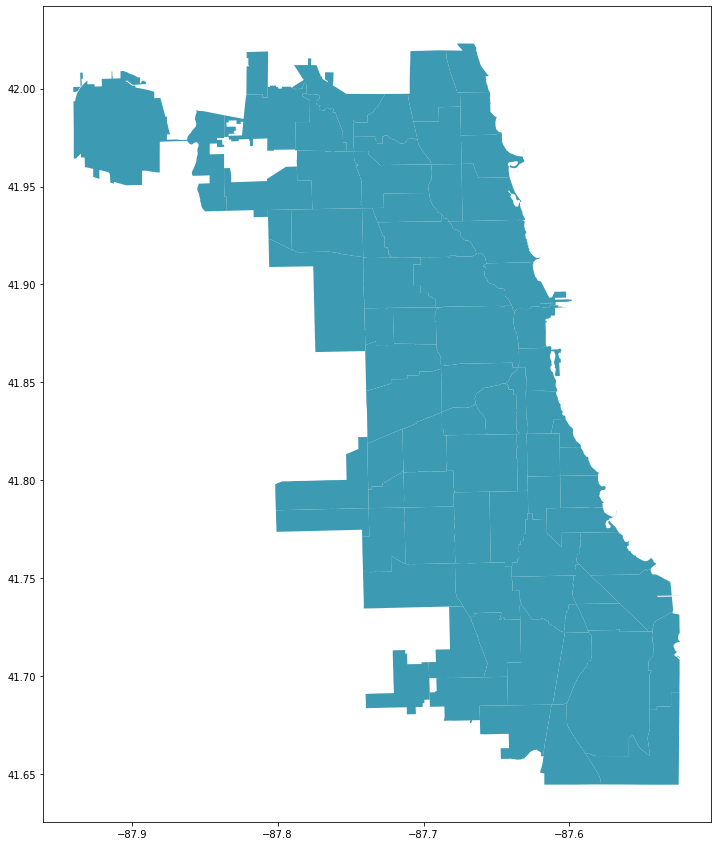

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
chicago_map.plot(ax = ax)

## Creating a GeoDataFrame and **plotting**

### Grouped start and end station using whole dataset

In [ ]:
grouped_stations.head()

,start_lng_lat,end_lng_lat,count,ride_length_mean,ride_length_median,distance_mean,distance_median
1934133,"(-87.6, 41.79)","(-87.6, 41.79)",21355,4.308348,3.250,0.000000,0.000000
1891188,"(-87.612043, 41.892278)","(-87.612043, 41.892278)",10686,42.056553,32.675,0.000000,0.000000
1857813,"(-87.616743, 41.880958)","(-87.616743, 41.880958)",6283,37.174689,29.650,0.000000,0.000000
1959681,"(-87.59, 41.8)","(-87.59, 41.8)",6262,11.578390,3.880,0.000000,0.000000
1935143,"(-87.6, 41.79)","(-87.59, 41.8)",5908,8.314897,7.070,1.386964,1.386964


In [ ]:
# Creating geometry using a column with tuple lng, lat
g1 = [Point(x) for x in grouped_stations['start_lng_lat']]
#geometry_end = [Point(x) for x in geometry_start['end_station_lng_lat_']]

In [ ]:
# Create GeoDataFrame

# geo_df = gpd.GeoDataFrame(grouped_start, crs="EPSG:4326", geometry=geometry_start)
grouped_geo_df = gpd.GeoDataFrame(grouped_stations, crs="EPSG:4326", geometry=g1)


In [ ]:
size1 = grouped_geo_df['count'].to_numpy()
s1 = [s*0.1 for s in size1]

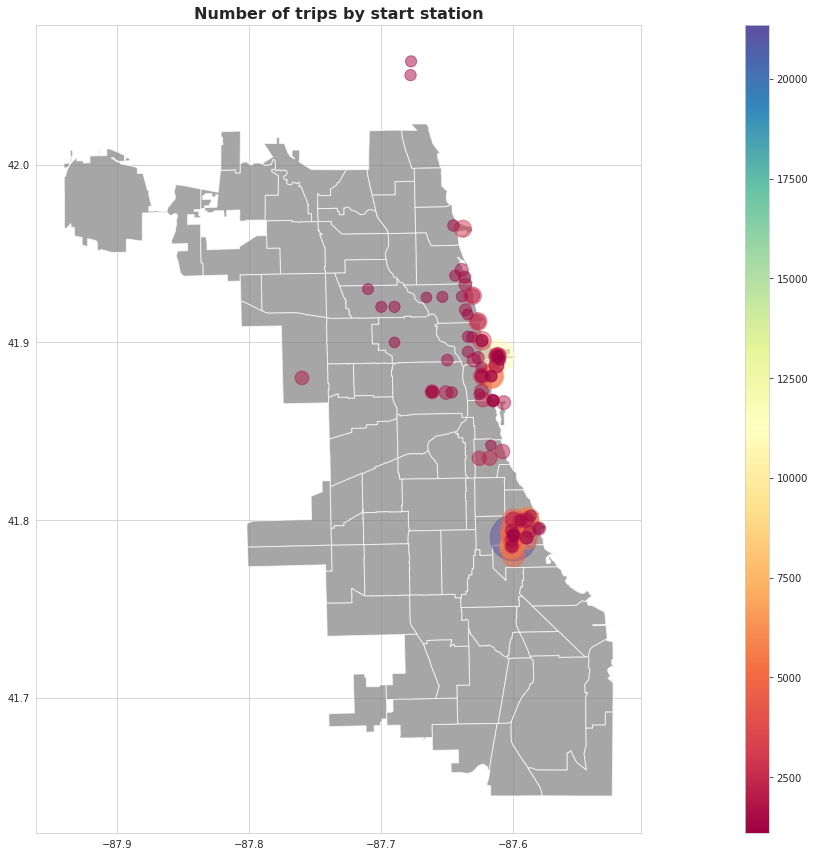

In [267]:
with sns.axes_style('whitegrid'):
  fig, ax = plt.subplots(figsize = (15,15))
  plt.title('Number of trips by start station', loc="center", fontsize=16, fontweight="bold")
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="3%", pad=0)
  chicago_map.plot(ax = ax, alpha=0.7, color="grey")
  grouped_geo_df.head(100).plot(ax=ax, column='count', markersize=s1, marker="o", alpha=0.5, cmap="Spectral", legend=True, cax=cax)
  #cax.set_ylabel('Number of trips by start station', rotation=90, fontsize=14)
  cax.tick_params(labelsize='10')
  



### Grouped start and end station using sampled dataset

In [277]:
grouped_big_sample.head()

,start_lng_lat,end_lng_lat,count,ride_length_mean,ride_length_median,distance_mean,distance_median,geometry
52494,"(-87.6, 41.79)","(-87.6, 41.79)",419,4.198473,3.37,0.000000,0.000000,POINT (-87.60000 41.79000)
51483,"(-87.612043, 41.892278)","(-87.612043, 41.892278)",136,43.850294,37.80,0.000000,0.000000,POINT (-87.61204 41.89228)
52283,"(-87.6010727606, 41.78509714636)","(-87.6014497734, 41.79430062054)",126,6.144048,4.56,1.023858,1.023858,POINT (-87.60107 41.78510)
53135,"(-87.59, 41.8)","(-87.59, 41.8)",123,12.912602,4.20,0.000000,0.000000,POINT (-87.59000 41.80000)
52694,"(-87.599861, 41.791478)","(-87.6010727606, 41.78509714636)",114,5.005263,4.18,0.716597,0.716597,POINT (-87.59986 41.79148)


In [ ]:
# Creating geometry using a column with tuple lng, lat
gs = [Point(x) for x in grouped_big_sample['start_lng_lat']]
#geometry_end = [Point(x) for x in geometry_start['end_station_lng_lat_']]

In [ ]:
# Create GeoDataFrame

# geo_df = gpd.GeoDataFrame(grouped_start, crs="EPSG:4326", geometry=geometry_start)
grouped_geo_df_sample = gpd.GeoDataFrame(grouped_big_sample, crs="EPSG:4326", geometry=gs)


In [ ]:
grouped_geo_df_sample = grouped_geo_df_sample.sort_values(by='count', ascending=True)

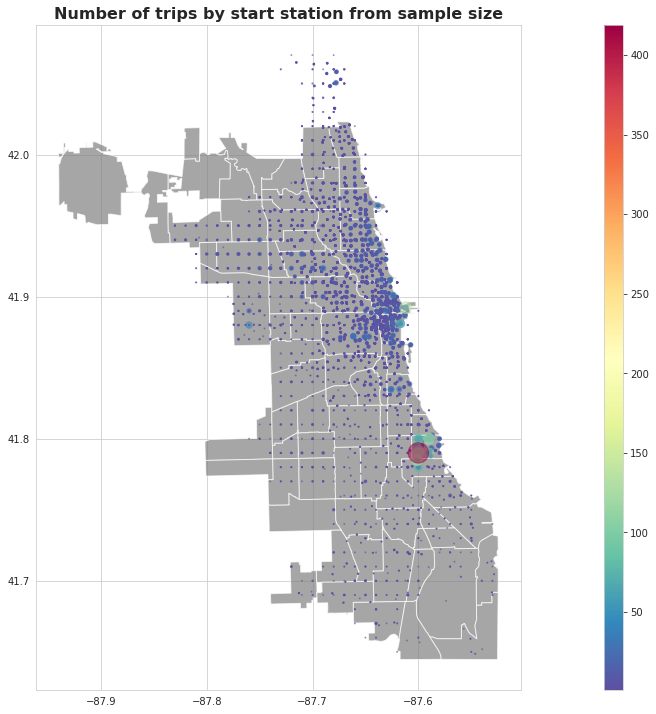

In [279]:
with sns.axes_style('whitegrid'):
  fig, ax = plt.subplots(figsize = (12,14))
  plt.title('Number of trips by start station from sample size', loc="center", fontsize=16, fontweight="bold")
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="3%", pad=0)
  chicago_map.plot(ax = ax, alpha=0.7, color="grey")
  grouped_geo_df_sample.plot(ax=ax, column="count", markersize='count', marker="o", alpha=0.5, cmap="Spectral_r", legend=True, cax=cax)
  cax.tick_params(labelsize='10')  

In [285]:
sc_list = grouped_geo_df_sample['count'].to_numpy()
sc = [s*15 for s in sc_list]

sl_list = grouped_geo_df_sample['ride_length_median'].to_numpy()
sl = [s*5 for s in sl_list]

sd_list = grouped_geo_df_sample['distance_median'].to_numpy()
sd = [s*15 for s in sd_list]

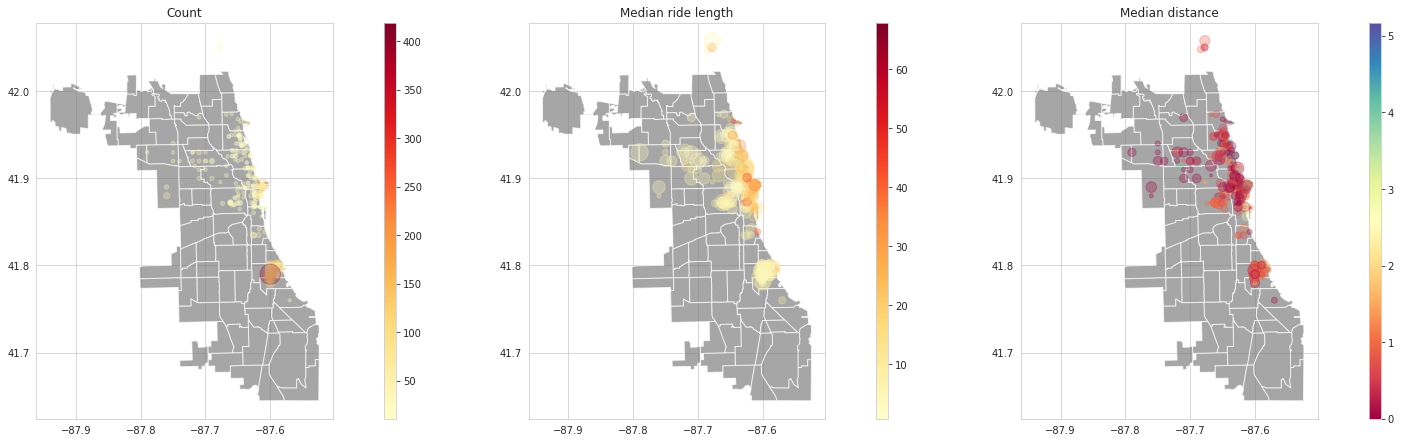

In [305]:


with sns.axes_style('whitegrid'):
  fig, axes = plt.subplots(1, 3, figsize = (25,10))
  fig.suptitle('', fontsize=16, fontweight="bold", y=0.85)

  
  divider = make_axes_locatable(axes[0])
  cax = divider.append_axes("right", size="3%", pad=0)

  chicago_map.plot(ax=axes[0], alpha=0.7, color="grey")
  grouped_geo_df_sample.query('count > 10').plot(ax=axes[0], markersize='count', marker="o", alpha=0.3, cmap="YlOrRd", column="count", legend=True, cax=cax)
  axes[0].set_title("Count")

  divider = make_axes_locatable(axes[1])
  cax = divider.append_axes("right", size="3%", pad=0)

  chicago_map.plot(ax=axes[1], alpha=0.7, color="grey")
  grouped_geo_df_sample.query('count > 10').plot(ax=axes[1], markersize=sl, marker="o", alpha=0.3, cmap="YlOrRd", column='ride_length_median', legend=True, cax=cax)
  axes[1].set_title("Median ride length")

  divider = make_axes_locatable(axes[2])
  cax = divider.append_axes("right", size="3%", pad=0)

  chicago_map.plot(ax=axes[2], alpha=0.7, color="grey")
  grouped_geo_df_sample.query('count > 10').plot(ax=axes[2], markersize=sd, marker="o", alpha=0.3, cmap="Spectral", column='distance_median', legend=True, cax=cax)
  axes[2].set_title("Median distance")



### **Grouped Members** from whole dataset

In [ ]:
grouped_member_station.head(50)

,start_lng_lat,end_lng_lat,count,ride_length_mean,ride_length_median,distance_mean,distance_median
1103204,"(-87.6, 41.79)","(-87.6, 41.79)",19460,4.100821,3.20,0.000000,0.000000
1120495,"(-87.59, 41.8)","(-87.59, 41.8)",5324,11.516414,3.78,0.000000,0.000000
1096565,"(-87.6010727606, 41.78509714636)","(-87.599861, 41.791478)",5081,4.894432,3.78,0.716597,0.716597
1096559,"(-87.6010727606, 41.78509714636)","(-87.6014497734, 41.79430062054)",4957,5.503540,4.67,1.023858,1.023858
1109275,"(-87.599861, 41.791478)","(-87.6010727606, 41.78509714636)",4857,4.819934,3.98,0.716597,0.716597


In [ ]:
print(grouped_member_station.head(50)['count'].min())
print(grouped_member_station.head(50)['count'].max())

852
19460


In [ ]:
# Creating geometry using a column with tuple lng, lat
g2 = [Point(x) for x in grouped_member_station['start_lng_lat']]
#geometry_end = [Point(x) for x in geometry_start['end_station_lng_lat_']]


In [ ]:
# Create GeoDataFrame

geo_df_member = gpd.GeoDataFrame(grouped_member_station, crs="EPSG:4326", geometry=g2)


In [ ]:
size2 = geo_df_member['count'].to_numpy()
s2 = [s*0.1 for s in size2]

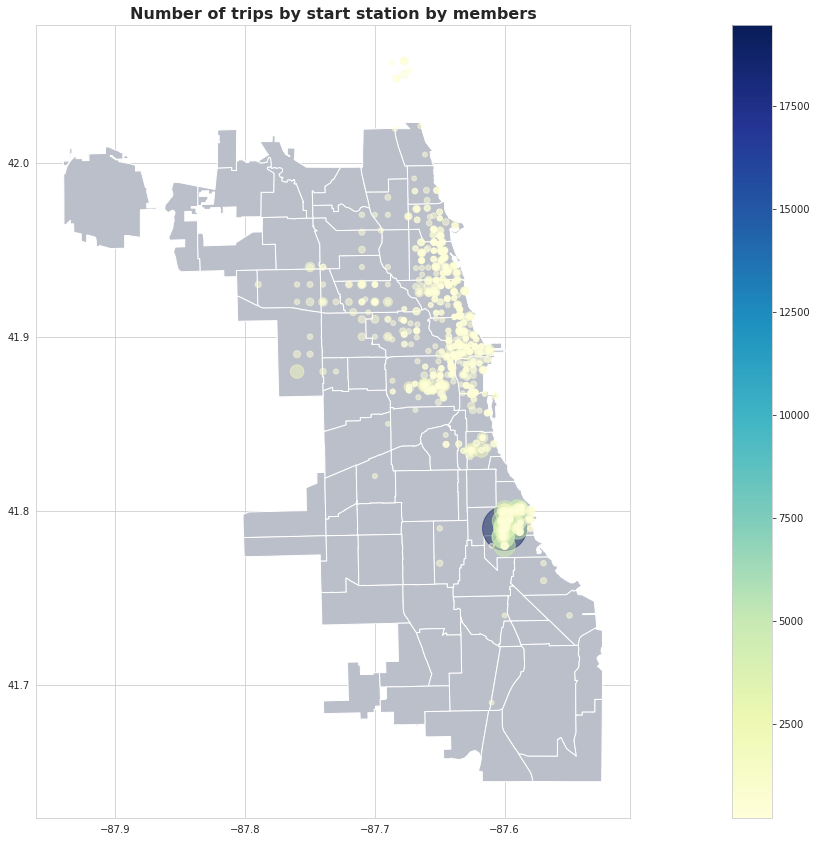

In [293]:
with sns.axes_style('whitegrid'):
  fig, ax = plt.subplots(figsize = (15,15))
  plt.title('Number of trips by start station by members', loc="center", fontsize=16, fontweight="bold")
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0)
  chicago_map.plot(ax = ax, color="#bbbfca")
  geo_df_member.head(1000).plot(ax=ax, markersize=s2, marker="o", alpha=0.5, cmap="YlGnBu", column='count', legend=True, cax=cax)



### **Grouped Casual Users** from whole dataset

In [ ]:
grouped_casual_station.head()

,start_lng_lat,end_lng_lat,count,ride_length_mean,ride_length_median,distance_mean,distance_median
916501,"(-87.612043, 41.892278)","(-87.612043, 41.892278)",9494,44.926034,35.325,0.000000,0.000000
892360,"(-87.616743, 41.880958)","(-87.616743, 41.880958)",5631,39.168450,30.780,0.000000,0.000000
892370,"(-87.616743, 41.880958)","(-87.612043, 41.892278)",4761,28.409149,19.970,1.317487,1.317487
817019,"(-87.62377664, 41.90096039)","(-87.62377664, 41.90096039)",2820,45.351926,40.680,0.000000,0.000000
916491,"(-87.612043, 41.892278)","(-87.616743, 41.880958)",2588,29.991596,17.475,1.317487,1.317487


In [ ]:
# Creating geometry using a column with tuple lng, lat
gc = [Point(x) for x in grouped_casual_station['start_lng_lat']]


In [ ]:
# Create GeoDataFrame

# geo_df = gpd.GeoDataFrame(grouped_start, crs="EPSG:4326", geometry=geometry_start)
geo_df_casual = gpd.GeoDataFrame(grouped_casual_station, crs="EPSG:4326", geometry=gc)


In [297]:
sizem = geo_df_member['count'].to_numpy()
sm = [s*0.1 for s in sizem]

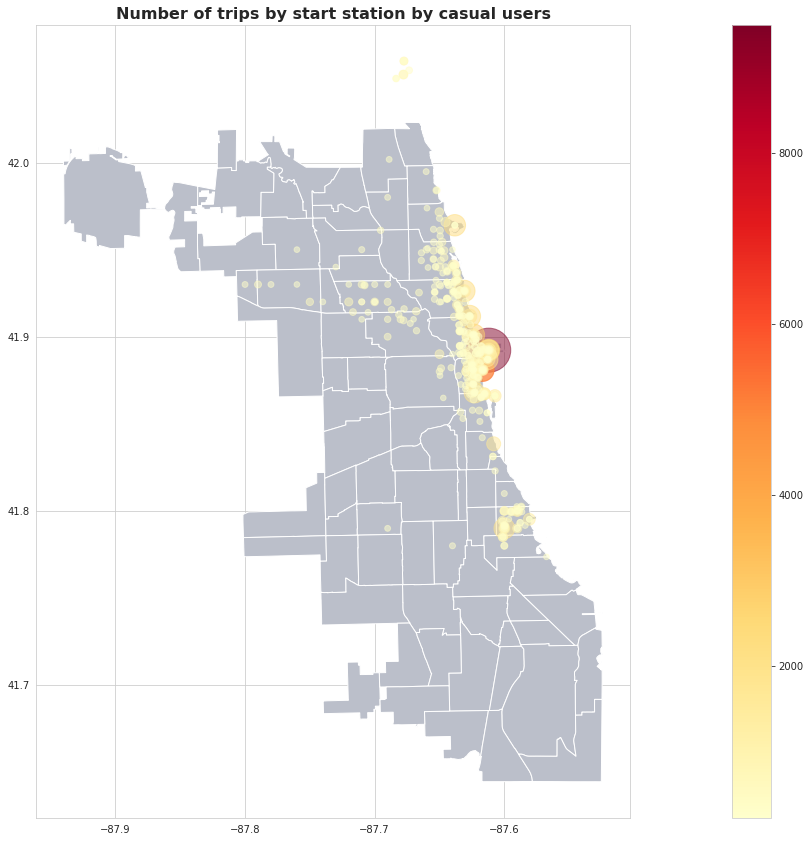

In [304]:
with sns.axes_style('whitegrid'):
  fig, ax = plt.subplots(figsize = (15,15))
  plt.title('Number of trips by start station by casual users', loc="center", fontsize=16, fontweight="bold")
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0)
  chicago_map.plot(ax = ax, color="#bbbfca")
  geo_df_casual.head(500).plot(ax=ax, markersize=sm, marker="o", alpha=0.5, cmap="YlOrRd", column='count', legend=True, cax=cax)


### Comparision between top stations used by casual users and members

In [ ]:
size = geo_df_member['count'].to_numpy()
s = [s*0.05 for s in size]

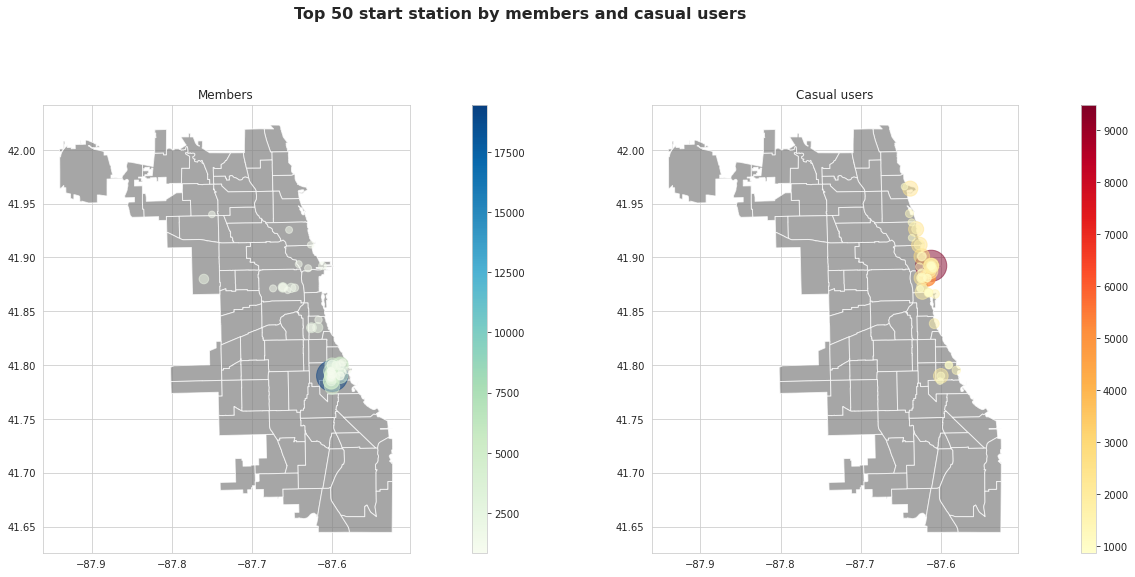

In [303]:
with sns.axes_style('whitegrid'):
  fig, axes = plt.subplots(1, 2, figsize = (20,10))
  fig.suptitle('Top 50 start station by members and casual users', fontsize=16, fontweight="bold", y=0.95)

  divider = make_axes_locatable(axes[0])
  cax = divider.append_axes("right", size="3%", pad=0)


  chicago_map.plot(ax=axes[0], alpha=0.7, color="grey")
  geo_df_member.head(50).plot(ax=axes[0], markersize=s, marker="o", alpha=0.5, cmap="GnBu", column="count", legend=True, cax=cax)
  axes[0].set_title("Members")

  divider = make_axes_locatable(axes[1])
  cax = divider.append_axes("right", size="3%", pad=0)

  chicago_map.plot(ax=axes[1], alpha=0.7, color="grey")
  geo_df_casual.head(50).plot(ax=axes[1], markersize=s, marker="o", alpha=0.5, cmap="YlOrRd", column="count", legend=True, cax=cax)
  axes[1].set_title("Casual users")



